In [33]:
%%capture --no-stderr
!pip install -U langgraph langchain-community langchain-openai tavily-python pandas
!pip install -qU langchain-text-splitters

In [2]:
#import getpass
import os
from dotenv import load_dotenv

#def _set_env(var: str):
#    if not os.environ.get(var):
#        os.environ[var] = getpass.getpass(f"{var}: ")

load_dotenv()
#_set_env("OPENAI_API_KEY")
#_set_env("TAVILY_API_KEY")

True

## Tools

In [3]:
import openai
import requests
from langchain_core.tools import tool
from datetime import date, datetime
from typing import Optional, Union
from langchain_text_splitters import RecursiveJsonSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from uuid import uuid4
from langchain_core.documents import Document
import faiss
import json
import concurrent.futures

In [36]:
@tool
def get_availability_for_hotels(
    townId: Optional[str] = None,
    checkin_date: Optional[str] = None,
    checkout_date: Optional[str] = None,
    adults: Optional[int] = 1,
    children: Optional[int] = 0,
    infants: Optional[int] = 0,
    ages: Optional[list[int]] = [],
    currency: Optional[int] = 1,
) -> list[dict]:
    """
    Get availability of hotels in a given town.

    Args:
    townId: The town ID.
    checkin_date (string): The check-in date.
    checkout_date (string): The check-out date.
    adults: The number of adults. Default is 1.
    children: The number of children. Default is 0.
    infants: The number of infants. Default is 0.
    ages: The ages of the children. Default is [].
    currency: The currency. Default is 1.

    Returns:
    A list of dictionaries containing the availability of
    hotels in the given town.

    Example:
    get_availability(townId='1234', checkin_date='2022-12-01', checkout_date='2022-12-05', adults=2, children=1)    
    """
    url = 'https://apibooking.ctsturismo.com/api/hotel/'

    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    json = {'townId': townId, 'checkin': checkin_date, 'checkout': checkout_date, 'rooms': [{'adults': adults, 'children': children, 'infants': infants, 'ages': ages}], 'currency': currency}
    response = requests.post(url, json=json, headers=headers)
    embeddings, json_chunks = split_json_response(response.json())
    return embeddings, json_chunks

@tool
def get_town_id_for_hotels(townName: str) -> list[dict]:
    """
    Get the town ID.

    Args:
    townName: The town or city name.

    Returns:
    The Town ID.

    Example:
    get_city_id('santiago')
    """
    url = f'https://apibooking.ctsturismo.com/api/city/dtt/?q={townName}'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.get(url, headers=headers)
    return response.json()[0]['dtt_id']

@tool
def get_availability_for_transport_and_excursions(
    townId: Optional[str] = None,
    checkin_date: Optional[str] = None,
    adults: Optional[int] = 1,
    children: Optional[int] = 0,
    infants: Optional[int] = 0,
    ages: Optional[list[int]] = [],
    currency: Optional[int] = 1,
) -> list[dict]:
    """
    Get availability of transport and excursions in a given town.

    Args:
    townId: The town ID.
    checkin_date (string): The check-in date.
    adults: The number of adults. Default is 1.
    children: The number of children. Default is 0.
    infants: The number of infants. Default is 0.
    ages: The ages of the children. Default is [].
    currency: The currency. Default is 1.

    Returns:
    A list of dictionaries containing the availability of
    transport and excursions in the given town.
    
    Example:
    get_availability_for_transport_and_excursions(townId='1234', checkin_date='2022-12-01', adults=2, children=1)
    """
    url = 'https://apibooking.ctsturismo.com/api/transport/'

    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    json = {'townId': townId, 'checkin': checkin_date, 'rooms': [{'adults': adults, 'children': children, 'infants': infants, 'ages': ages}], 'currency': currency}
    response = requests.post(url, json=json, headers=headers)
    result = split_json_response(response.json())
    return result

@tool
def get_town_id_for_transport_and_excursions(townName: str) -> list[dict]:
    """
    Get the town ID.

    Args:
    townName: The town or city name.

    Returns:
    The Town ID.

    Example:
    get_town_id_for_transport_and_excursions('santiago')
    """
    url = 'https://apibooking.ctsturismo.com/api-v2/city/'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.get(url, headers=headers)

    for town in response.json():
        if town['name'].lower() == townName.lower():
            return town['id']
        
    return None

@tool
def get_availability_for_transport_and_excursions(
    townId: Optional[str] = None,
    tipos: Optional[str] = None,
    fecha: Optional[str] = None,
    adults: Optional[int] = 1,
    children: Optional[int] = 0,
    currency: Optional[int] = 1,
    ) -> list[dict]:
    """
    Get availability of transport or excursions in a given town.

    Args:
    townId: The town ID.
    tipos: The type of service. 1 is for transport, and 2 is for excursions.
    fecha (string): The date.
    adults: The number of adults. Default is 1.
    children: The number of children. Default is 0.
    currency: The currency. 1 is for CLP, and 2 is for USD. Default is 1.

    Returns:
    A list of dictionaries containing the availability of
    transport or excursions in the given town.

    Example:
    get_availability_for_transport_and_excursions(townId='1234', tipos='1', fecha='2022-12-01', adults=2, children=1, currency=1)
    """

    url = f'https://apibooking.ctsturismo.com/api-v2/availability/?townId={townId}&tipos={tipos}&fecha={fecha}&adults={adults}&children={children}&currency={currency}'
    ctsToken = os.getenv("CTS_TOKEN")
    headers = {'Authorization': f'token {ctsToken}'}
    response = requests.get(url, headers=headers)
    return response.json()

### Controllers

In [37]:
def split_json_response(json_response):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=100
        )
    
    #json_str = json.dumps(json_response, indent=2)
    json_chunks = splitter.split_text(json_response)
    embeddings_model = OpenAIEmbeddings(
        model="text-embedding-ada-002",
    )

    # # # def get_embedding(chunk):
    # # #     return embeddings_model.embed_query(chunk)
    
    # # # with concurrent.futures.ThreadPoolExecutor() as executor:
    # # #     embeddings = list(executor.map(get_embedding, json_chunks))
    
    # # # return embeddings, json_chunks    

    # embeddings = []
    # for chunk in json_chunks:
    #     embedding = embeddings_model.embed_query(chunk)
    #     embeddings.append(embedding)
    # return embeddings, json_chunks


    # splitter = RecursiveJsonSplitter(max_chunk_size=300)
    # json_chunks = splitter.split_json(json)
    # embeddings = OpenAIEmbeddings(
    #     model="text-embedding-3-small",
    # )
    # db = FAISS.from_documents(json_chunks, embeddings)
    # # index=faiss.IndexFlatL2(len(embeddings.embed_query(str(json))))
    # # vector_store = FAISS(
    # #     embedding_function=embeddings,
    # #     index=index,
    # #     docstore=InMemoryDocstore(),
    # #     index_to_docstore_id={},
    # # )

    # # documents = []
    # # for chunk in json_splitted:
    # #     if len(chunk) > 0:
    # #         documents.append(chunk)
    
    # # uuids = [str(uuid4()) for _ in range(len(documents))]
    # # result = vector_store.add_documents(documents=documents, ids=uuids)
    # result = db.as_retriever()
    # return result


def generate_hotels_availability_response(json_response):
    result = []
    hotel = {}
    for data in json_response['data']:
        hotel['hotelId'] = data['id']
        hotel['hotelName'] = data['name']
        hotel['hotelAddress'] = data['address']

        hotel['price'] = data['availability'][0]['price_value_with_tax']
        result.append(hotel)

    return result

In [ ]:
town = get_town_id_for_transport_and_excursions('Providencia')
print(town)

In [35]:
hotels = get_availability_for_hotels(townId='51', checkin_date='2024-10-04', checkout_date='2024-10-05', adults=2, children=1, infants=0, ages=[5])
print(hotels)

[{'hotelId': 160, 'hotelName': 'Casa Bueras Hotel Boutique', 'hotelAddress': 'Coronel Santiago Bueras 188, 8320135 Santiago, Región Metropolitana, Chile', 'price': 247359}, {'hotelId': 160, 'hotelName': 'Casa Bueras Hotel Boutique', 'hotelAddress': 'Coronel Santiago Bueras 188, 8320135 Santiago, Región Metropolitana, Chile', 'price': 247359}, {'hotelId': 160, 'hotelName': 'Casa Bueras Hotel Boutique', 'hotelAddress': 'Coronel Santiago Bueras 188, 8320135 Santiago, Región Metropolitana, Chile', 'price': 247359}, {'hotelId': 160, 'hotelName': 'Casa Bueras Hotel Boutique', 'hotelAddress': 'Coronel Santiago Bueras 188, 8320135 Santiago, Región Metropolitana, Chile', 'price': 247359}, {'hotelId': 160, 'hotelName': 'Casa Bueras Hotel Boutique', 'hotelAddress': 'Coronel Santiago Bueras 188, 8320135 Santiago, Región Metropolitana, Chile', 'price': 247359}, {'hotelId': 160, 'hotelName': 'Casa Bueras Hotel Boutique', 'hotelAddress': 'Coronel Santiago Bueras 188, 8320135 Santiago, Región Metropol

In [ ]:
print("Fragmentos JSON divididos:", json_chunks)
print("Embeddings calculados:", embeddings)

### Utilities

In [38]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

## Agent

### State

In [39]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Agent

In [40]:
#from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Tu nombre es CTS Travel Assistant."
            "Eres un asistente de atención al cliente de CTS Turismo (Chilean Travel Services)."
            "CTS Turismo es una empresa de turismo que ofrece servicios turísticos variados en Chile."
            "Los servicios que ofrecen son los siguientes: hoteles, excursiones, traslados y paquetes turísticos."
            "Hoteles: Reservas de hoteles en todo Chile."
            "Excursiones: Tours y actividades en diferentes ciudades y localidades de Chile."
            "Traslados: Transporte desde un punto a otro, como desde y hacia el aeropuerto o el terminal de buses, o bien desde y hacia la nieve o la playa, etc."
            "Paquetes turísticos: Combinación de hoteles, excursiones y traslados a un precio único."
            "Tu objetivo es ayudar a los usuarios a encontrar los servicios antes descritos y toda otra información relevante."
            "Una vez que el usuario haya encontrado el servicio que busca, y siempre que el usuario lo haya solicitado, debes reservar el servicio para el usuario."
            "Por defecto, debes dar tus respuestas en español. Sin embargo, si el usario te escribe en un idioma diferente, tus resppuestas deben ser en ese idioma."
            "Utiliza las herramientas (tools) proporcionadas para buscar hoteles, excusriones, traslados y paquetes y otra información que ayude en las consultas del usuario."
            "Cuando busques, debes ser persistente. Amplía los límites de tu consulta si la primera búsqueda no devuelve resultados."
            "Si una búsqueda resulta vacía, amplía la búsqueda antes de darte por vencido."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    get_town_id_for_hotels,
    get_availability_for_hotels
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

### Graph

In [41]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

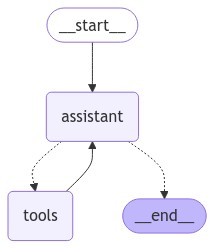

In [42]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Conversation

In [43]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hola, necesito un hotel en Santiago para 1 noche a partir del 4 de octubre, para mi esposa, mi hijo de 3 años y yo.",
    # "Hi there, i need a hotel in Torres del Paine for 1 night starting on October 4th, for me and my wife and my 3 years old son.",
    # "Olá, preciso de um hotel em Torres del Paine por 1 noite a partir de 4 de outubro, para mim, minha esposa e meu filho de 3 anos.",
    # "Bonjour, j'ai besoin d'un hôtel à Torres del Paine pour 1 nuit à partir du 4 octobre, pour moi, ma femme et mon fils de 3 ans",
    # "Am i allowed to update my flight to something sooner? I want to leave later today.",
    # "Update my flight to sometime next week then",
    # "The next available option is great",
    # "what about lodging and transportation?",
    # "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    # "OK could you place a reservation for your recommended hotel? It sounds nice.",
    # "yes go ahead and book anything that's moderate expense and has availability.",
    # "Now for a car, what are my options?",
    # "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    # "Cool so now what recommendations do you have on excursions?",
    # "Are they available while I'm there?",
    # "interesting - i like the museums, what options are there? ",
    # "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
#db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "townId": "51",
        "checkin": "2024-09-27",
        "checkout": "2024-09-28",
        "rooms": [{'adults': 2, 'children': 0, 'infants': 0, 'ages': []}],
        "currency": 1,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hola, necesito un hotel en Santiago para 1 noche a partir del 4 de octubre, para mi esposa, mi hijo de 3 años y yo.
================================== Ai Message ==================================
Tool Calls:
  get_town_id_for_hotels (call_7ZP4nZTUgw6TXVf5xIOuQErx)
 Call ID: call_7ZP4nZTUgw6TXVf5xIOuQErx
  Args:
    townName: Santiago
================================= Tool Message =================================
Name: get_town_id_for_hotels

51
================================== Ai Message ==================================
Tool Calls:
  get_availability_for_hotels (call_DOJvSCXe7wO3sKY4FzwoHa5r)
 Call ID: call_DOJvSCXe7wO3sKY4FzwoHa5r
  Args:
    townId: 51
    checkin_date: 2024-10-04
    checkout_date: 2024-10-05
    adults: 2
    children: 1
    ages: [3]
================================= Tool Message =================================
Name: get_availability_for_hotels

[{"hotelId": 254, "hotelName":

# VERSION 2

## State

In [ ]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

## Assistants

In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling flight updates. "
            " The primary assistant delegates work to you whenever the user needs help updating their bookings. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.
# The task delegation is a simple form of semantic routing / does simple intent detection
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Tu nombre es CTS Travel Assistant."
            "Eres un asistente de atención al cliente de CTS Turismo (Chilean Travel Services)."
            "CTS Turismo es una empresa de turismo que ofrece servicios turísticos variados en Chile."
            "Los servicios que ofrecen son los siguientes: hoteles, excursiones, traslados y paquetes turísticos."
            "Hoteles: Reservas de hoteles en todo Chile."
            "Excursiones: Tours y actividades en diferentes ciudades y localidades de Chile."
            "Traslados: Transporte desde un punto a otro, como desde y hacia el aeropuerto o el terminal de buses, o bien desde y hacia la nieve o la playa, etc."
            "Paquetes turísticos: Combinación de hoteles, excursiones y traslados a un precio único."
            "Tu objetivo es ayudar a los usuarios a encontrar los servicios antes descritos y toda otra información relevante."
            "Por defecto, debes dar tus respuestas en español. Sin embargo, si el usario te escribe en un idioma diferente, tus resppuestas deben ser en ese idioma."
            "Utiliza las herramientas (tools) proporcionadas para buscar hoteles, excusriones, traslados y paquetes y otra información que ayude en las consultas del usuario."
            "Si un cliente solicita crear, actualizar o cancelar una reserva de hotel, traslado o excursión; o bien, al momento de buscar un hotel, excursion o traslado, necesita recomendaciones especializadas"
            "delega la tarea en el asistente especializado adecuado invocando la herramienta correspondiente. No podrás realizar este tipo de cambios tu mismo"
            "El usuario no conoce los distintos asistentes especializados, así que no los menciones; limítate a delegar tranquilamente mediante llamadas a funciones"
            "Proporciona información detallada al cliente, y comprueba siempre dos veces la consulta antes de concluir que la información no está disponible"
            "Cuando busques, debes ser persistente. Amplía los límites de tu consulta si la primera búsqueda no devuelve resultados."
            "Si una búsqueda resulta vacía, amplía la búsqueda antes de darte por vencido."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
primary_assistant_tools = [
    TavilySearchResults(max_results=1),
    get_availability_for_hotels,
    get_availability_for_transport_and_excursions,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

## Utility

In [ ]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

## Graph

In [ ]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

In [ ]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
) -> Literal[
    "update_flight_sensitive_tools",
    "update_flight_safe_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges("update_flight", route_update_flight)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [ ]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
) -> Literal[
    "update_flight_sensitive_tools",
    "update_flight_safe_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges("update_flight", route_update_flight)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [ ]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
) -> Literal[
    "leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges("book_hotel", route_book_hotel)

In [ ]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
) -> Literal[
    "book_excursion_safe_tools",
    "book_excursion_sensitive_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges("book_excursion", route_book_excursion)

In [ ]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
) -> Literal[
    "primary_assistant_tools",
    "enter_update_flight",
    "enter_book_hotel",
    "enter_book_excursion",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_update_flight": "enter_update_flight",
        "enter_book_car_rental": "enter_book_car_rental",
        "enter_book_hotel": "enter_book_hotel",
        "enter_book_excursion": "enter_book_excursion",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Conversation

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)